## Assignment 3:  Convolutional networks for TF ChIP-seq data

In this assignment you will build on the convolutional networks we looked at in class and work on ChIP-seq data for four transcription factors in arabidopsis.


### Part 1: Data Preparation

In this assignment you will work with ChIP-seq for three arabidopsis transcription factors:  AGL16, GRF1, and AMS.  The peaks that represent their binding sites in the arabidopsis genome are available in the following links:

* AGL16 ([bed file](https://biobigdata.nju.edu.cn/ChIPHub_download/arabidopsis_thaliana/SRP187795/hammock/AGL16.target.all.bed.gz))
* GRF1 ([bed file](https://biobigdata.nju.edu.cn/ChIPHub_download/arabidopsis_thaliana/SRP002566/hammock/SRX021610.peak.all.bed.gz))
* AMS ([bed file](https://biobigdata.nju.edu.cn/ChIPHub_download/arabidopsis_thaliana/SRP188198/hammock/SRX5507861.peak.all.bed.gz))

These files are in [bed format](https://en.wikipedia.org/wiki/BED_(file_format)), and contain the information on the genomic locations where the ChIP-seq peaks have been detected.  The linked wikipedia article provides the information you need about the format of these files.  Your task is to extract sequences of length 500 centered at the location of each peak, which you will provide as input to the convolutional network you train.  

In order to extract the sequences associated with the peaks you will need the genomic sequence for arabidopsis.  This is available from the [Ensembl plants arabidopsis portal](https://plants.ensembl.org/Arabidopsis_thaliana/Info/Index).  In that page click on "Download DNA sequence (FASTA)", and the first five files provide the sequences for the five arabidopsis chromosomes.

For reference, we computed the sequences associated with AGL16 peaks (link is in the assignment page in Canvas).

Your final data preparation task is to prepare a labeled dataset with positive examples that correspond to the peak sequences.  As negative examples, use random permutations of the positive examples.  Create one permutation from each positive example.  How many examples did you obtain for each transcription factor?

In [1]:
# Tasks
# - Load data
# given bed file -> convert to fasta file (example database\AGL16_peak_seq.fasta)
# - Generate dataset
# given a fasta file -> a dataset with negative example made from postive


# I used in class code on this section of the assignment to load in the data.
# I am sorry if this is not allowed but being able to use your chipseq_dataset 
# helped me understand the dataloading process much better.

In [2]:
# lets look at the bed files 
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

positions = {}
with open('database\AGL16.target.all.bed') as f:
    for line in f:
        chr, start, stop, name, score, strand, thickStart, thickEnd, itemRgb, blockcount, blockSize, blockStart, _, _ = line.split()
        # idk what the last two are there is only supposed to be 12 according to wikipedia
        positions[name] = (chr, int(start), int(stop), (int(start)+int(stop))//2)

genome_locations = [r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.1.fa',
                    r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.2.fa',
                    r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.3.fa',
                    r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.4.fa',
                    r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.5.fa']
genome = {}
for l in genome_locations:
    genome = genome | SeqIO.to_dict(SeqIO.parse(open(l), 'fasta'), lambda rec: 'Chr'+rec.name)

# Extract 500bp sequences centered at midpoints
sequences = []
for name, (chr, start, stop, mid_point) in positions.items():
    # Calculate the start and end positions for a 500bp sequence centered at midpoint
    seq_start = max(0, mid_point - 250)  # Ensure we don't go below 0
    seq_end = min(len(genome[chr].seq), mid_point + 250)  # Ensure we don't go beyond chromosome length
    
    # Extract the sequence
    sequence = genome[chr].seq[seq_start:seq_end]
    
    # Create a SeqRecord
    record = SeqRecord(sequence, id=name, description=f"Chromosome {chr}, midpoint {mid_point}")
    sequences.append(record)

# Write to FASTA file
SeqIO.write(sequences, "AGL16_peak_seq.fasta", "fasta")
print(f"Extracted {len(sequences)} sequences and saved to FASTA file.")




Extracted 4328 sequences and saved to FASTA file.


In [3]:
import os
import numpy as np
from Bio import SeqIO

def get_sequences(genome_paths = [r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.1.fa',
                                r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.2.fa',
                                r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.3.fa',
                                r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.4.fa',
                                r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.5.fa'], 
                                bed_path='database\AGL16.target.all.bed',
                                len_of_seqs=500):
    
    positions = {}
    with open(bed_path) as f:
        for line in f:
            # chr, start, stop, name, score, strand, thickStart, thickEnd, itemRgb, blockcount, blockSize, blockStart, _, _ = line.split()
            # idk what the last two are there is only supposed to be 12 according to wikipedia

            split = line.split()
            chr, start, stop, name = split[0], split[1], split[2], split[3]
            positions[name] = (chr, int(start), int(stop), (int(start)+int(stop))//2)

    genome = {}
    for l in genome_paths:
        genome = genome | SeqIO.to_dict(SeqIO.parse(open(l), 'fasta'), lambda rec: 'Chr'+rec.name)

    sequences = []
    for name, (chr, start, stop, mid_point) in positions.items():
        seq_start = max(0, mid_point - len_of_seqs//2)
        seq_end = min(len(genome[chr].seq), mid_point + len_of_seqs//2) 
        
        if seq_start == 0 or seq_end == len(genome[chr].seq):
            continue

        sequence = genome[chr].seq[seq_start:seq_end]
        
        record = SeqRecord(sequence, id=name, description=f"Chromosome {chr}, midpoint {mid_point}")
        sequences.append(record)

    # Write to FASTA file
    SeqIO.write(sequences, os.path.basename(bed_path)+".fasta", "fasta")
    print(f"Extracted {len(sequences)} sequences and saved to FASTA file.")
    return sequences

In [4]:
import numpy as np
nucleotide_indexes = {'a':0, 't':1, 'g':2, 'c':3, 'w': (0,1), 'n': (0,1,2,3), 'y': (1, 3), 's': (2, 3)}
nucleotide_values = {'a':1, 't':1, 'g':1, 'c':1, 'w': 0.5, 'n': 0.25, 'y': 0.5, 's': 0.5}

def one_hot_encode(seq):
    oneHotEncode = np.zeros([4,len(seq)])
    for i, n in enumerate(seq):
        oneHotEncode[nucleotide_indexes[n.lower()], i] = nucleotide_values[n.lower()]
    return oneHotEncode

def generate_dataset(sequences):
    positive_seqs = []
    negative_seqs = []

    for seq_record in sequences:
        positive_seqs.append(one_hot_encode(str(seq_record.seq)))
        
        seq_list = list(str(seq_record.seq))
        np.random.shuffle(seq_list)
        permuted_seq = ''.join(seq_list)
        negative_seqs.append(one_hot_encode(permuted_seq))

    positive_labels = np.ones(len(positive_seqs))
    negative_labels = np.zeros(len(negative_seqs))

    X = positive_seqs + negative_seqs
    y = np.concatenate([positive_labels, negative_labels])

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = [X[i] for i in indices]
    y = y[indices]

    print(f"Dataset created with {len(positive_seqs)} positive examples and {len(negative_seqs)} negative examples")
    return X, y

In [5]:
X, y = generate_dataset(get_sequences())

Extracted 4327 sequences and saved to FASTA file.
Dataset created with 4327 positive examples and 4327 negative examples


In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import sklearn as sk

class chipseq_dataset(Dataset):
    def __init__(self, xy):
        self.x_data=np.array([el[0] for el in xy],dtype=np.float32)
        self.y_data =np.array([el[1] for el in xy ],dtype=np.float32)
        self.x_data = torch.from_numpy(self.x_data)
        self.y_data = torch.from_numpy(self.y_data)
        self.length=len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

X_train_data, X_temp_data, y_train_data, y_temp_data = train_test_split(X, y, test_size=0.4)
X_valid_data, X_test_data, y_valid_data, y_test_data = train_test_split(X_temp_data, y_temp_data, test_size=0.5)

train_dataset=chipseq_dataset([(x, y) for (x, y) in zip(X_train_data, y_train_data)])
test_dataset=chipseq_dataset([(x, y) for (x, y) in zip(X_test_data, y_test_data)])
valid_dataset=chipseq_dataset([(x, y) for (x, y) in zip(X_valid_data, y_valid_data)])

batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,shuffle=True)

### Part 2:  

As discussed in class, deeper networks with multiple layers of convolution *can* improve a network's performance.  Your task here is to extend the implementation provided in class to have three layers of convolution.  In addition, implement early stopping based on performance on the validation set (essentially, continue training until the validation loss stops decreasing).
Finally, train each network two or three times, and choose the best performing network based on the performance on the validation set as the one to evaluate on the test set.
In your experiments, set aside 20% of the data for testing, 20% for validation, and 60% for training.
Compare the accuracy of your network to that of a one layer CNN.  Accuracy should be measured using the area under the ROC curve.  In the next part of the assignment you will get to tune its parameters to try and improve its performance.
Note that for all datasets you should be able to obtain accuracy of around 0.9 or better.

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class CNN(nn.Module):
    def __init__(self, num_motif=8, motif_len=12, sigma_conv=0.01, sigma_w=0.01, drop_out=None):
        super(CNN, self).__init__()
        # width parameter for initialization of convolutional filters
        self.sigma_conv = sigma_conv
        self.sigma_w = sigma_w
        self.input_channels = 4
        self.activation = nn.ReLU()
        if drop_out is not None:
            self.input_dropout = nn.Dropout(drop_out)
        else:
            self.input_dropout = None

        # First convolutional layer
        self.conv1_weights = torch.empty(num_motif, self.input_channels, motif_len, dtype=torch.float).to(device)
        self.conv1_bias = torch.empty(num_motif, dtype=torch.float).to(device)
        torch.nn.init.normal_(self.conv1_weights, std=sigma_conv)
        torch.nn.init.normal_(self.conv1_bias)
        self.conv1_weights.requires_grad = True
        self.conv1_bias.requires_grad = True
        # print(self.conv1_weights.shape)
        # print(self.conv1_bias.shape)


        # Second convolutional layer
        self.conv2_weights = torch.empty(num_motif, num_motif, motif_len, dtype=torch.float).to(device)
        self.conv2_bias = torch.empty(num_motif, dtype=torch.float).to(device)
        torch.nn.init.normal_(self.conv2_weights, std=sigma_conv)
        torch.nn.init.normal_(self.conv2_bias)
        self.conv2_weights.requires_grad = True
        self.conv2_bias.requires_grad = True
        # print(self.conv2_weights.shape)
        # print(self.conv2_bias.shape)


        # Third convolutional layer
        self.conv3_weights = torch.empty(num_motif, num_motif, motif_len, dtype=torch.float).to(device)
        self.conv3_bias = torch.empty(num_motif, dtype=torch.float).to(device)
        torch.nn.init.normal_(self.conv3_weights, std=sigma_conv)
        torch.nn.init.normal_(self.conv3_bias)
        self.conv3_weights.requires_grad = True
        self.conv3_bias.requires_grad = True
        # print(self.conv3_weights.shape)
        # print(self.conv3_bias.shape)

        # Fully connected layer
        self.FC_size = num_motif
        self.w = torch.empty(self.FC_size, 1, dtype=torch.float).to(device)
        self.b = torch.empty(1, dtype=torch.float).to(device)
        torch.nn.init.normal_(self.w, mean=0, std=self.sigma_w)
        torch.nn.init.normal_(self.b, mean=0, std=self.sigma_w)
        self.w.requires_grad = True
        self.b.requires_grad = True
        # print(self.w.shape)
        # print(self.b.shape)


    def get_weights(self):
        return [
            self.conv1_weights, self.conv1_bias,
            self.conv2_weights, self.conv2_bias,
            self.conv3_weights, self.conv3_bias,
            self.w, self.b
        ]

    def forward(self, x):
        # I think I am wrong here, this is not a CNN with only 3 convolutional layers.
        # I was unable to figure out how to get it to compress to a float as an output
        # without the fully connected layer. 

        if self.input_dropout is not None:
            x = self.input_dropout(x)
        # print(x.shape)

        # First convolutional layer
        x = nn.functional.conv1d(x, self.conv1_weights, bias=self.conv1_bias, stride=1, padding=0)
        x = self.activation(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        # print(x.shape)

        # Second convolutional layer
        x = nn.functional.conv1d(x, self.conv2_weights, bias=self.conv2_bias, stride=1, padding=0)
        x = self.activation(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        # print(x.shape)

        # Third convolutional layer
        x = nn.functional.conv1d(x, self.conv3_weights, bias=self.conv3_bias, stride=1, padding=0)
        x = self.activation(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        # print(x.shape)

        x, _ = torch.max(x, dim=2)

        x = torch.matmul(x, self.w) + self.b
        # print(x.shape)

        return torch.sigmoid(x)

Using cuda device


In [8]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y.view(-1, 1))
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y.view(-1, 1)).item()
            pred = np.heaviside(y_pred.detach().cpu().numpy().reshape(len(y_pred))-0.5,0)
            correct += (pred == y.detach().cpu().numpy().reshape(len(y))).sum()
    validation_loss /= num_batches
    correct /= size
    if epoch%10 == 0 :
        print(f"Validation Accuracy: {correct:>8f}\nAvg test loss: {validation_loss:>8f} \n")
    return validation_loss


In [9]:
model1 = CNN(24, 20, 0.1, 0.1).to(device)

# optimizer = torch.optim.SGD(model.get_weights(),
#                             lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-06);


optimizer1 = torch.optim.Adam(model1.get_weights(), lr=0.001)

In [10]:
def train(model, tl, vl, op, sr):
    epochs = 200
    loss_fn = nn.BCELoss()

    train_loss = []
    validation_loss = []
    for t in range(epochs):
        if t % 10 == 0 :
            print(f"Epoch {t}\n-------------------------------")
        loss = train_epoch(tl, model, loss_fn, op, t)
        train_loss.append(loss)
        loss = validation(vl, model, loss_fn, t)
        validation_loss.append(loss)
        ratio = train_loss[-1]/validation_loss[-1]
        
        if ratio < sr: # early stopping
            break
    print("Done!")
    return [train_loss, validation_loss]

[train_loss, validation_loss] = train(model1, train_loader, valid_loader, optimizer1, 0.6)

Epoch 0
-------------------------------
training loss: 0.698497
Validation Accuracy: 0.538417
Avg test loss: 0.685866 

Epoch 10
-------------------------------
training loss: 0.216211
Validation Accuracy: 0.892548
Avg test loss: 0.253964 

Done!


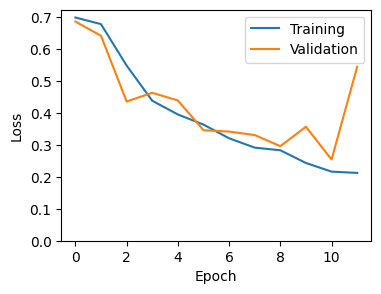

In [11]:
from matplotlib import pyplot as plt
def plot_loss(tl, vl):
    plt.figure(figsize=(4,3))
    plt.plot(tl, label='Training')
    plt.plot(vl, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0)
    plt.legend();

plot_loss(*[train_loss, validation_loss])

In [12]:
from sklearn import metrics

def validate_w_AUC(model, loader):
    with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for i, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            pred=output.cpu().detach().numpy().reshape(output.shape[0])
            labels=target.cpu().numpy().reshape(output.shape[0])
            pred_list.append(pred)
            labels_list.append(labels)
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        auc = metrics.roc_auc_score(labels, predictions)
        return auc

auc = validate_w_AUC(model1, valid_loader)

print(f'AUC on validation data: {auc}')

AUC on validation data: 0.9661108812025259


C:\Users\Jack\AppData\Local\Temp\ipykernel_41136\3277894707.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


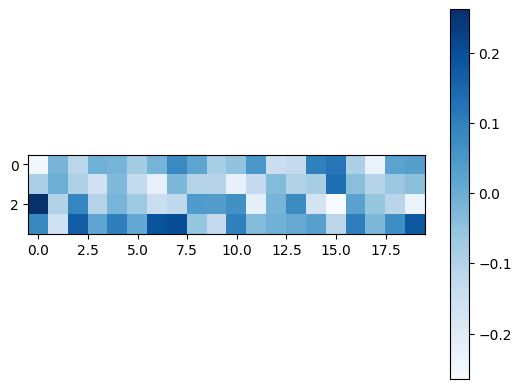

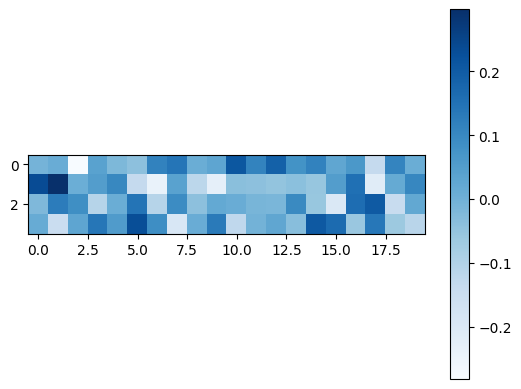

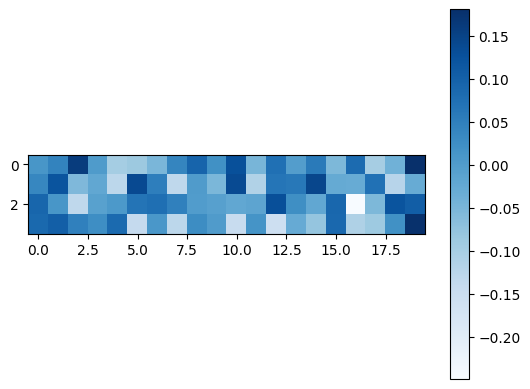

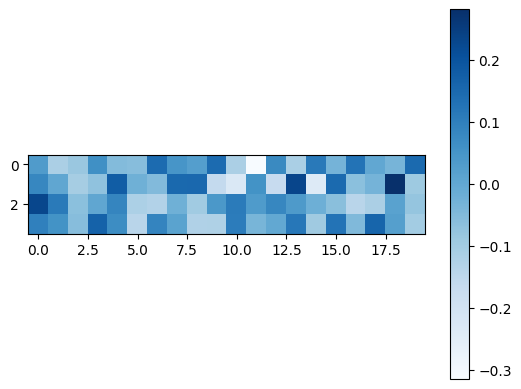

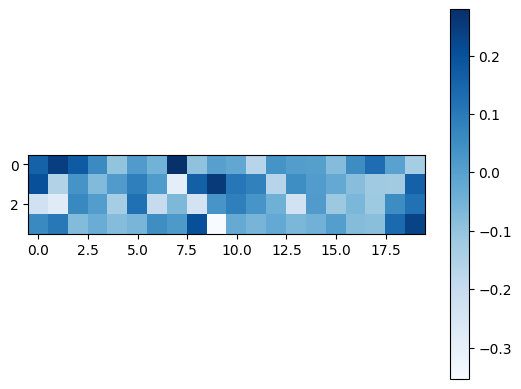

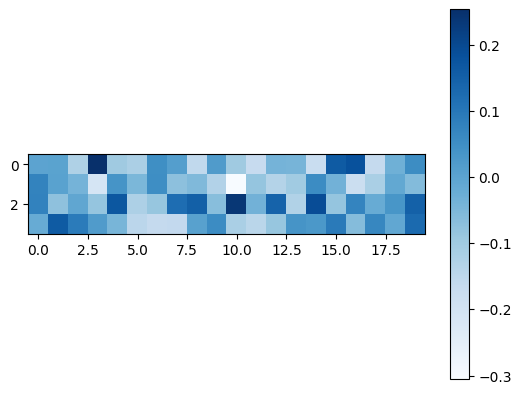

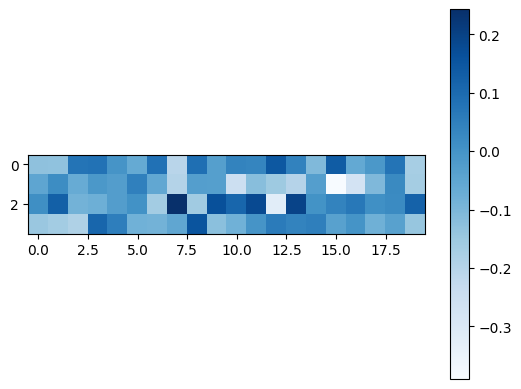

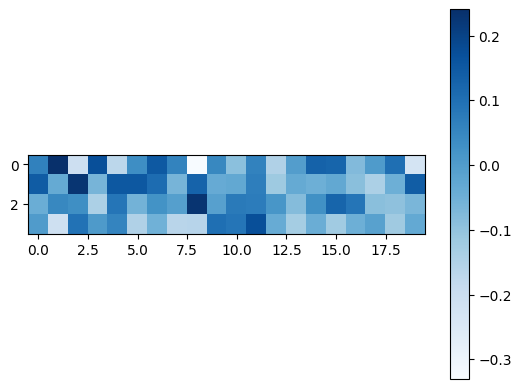

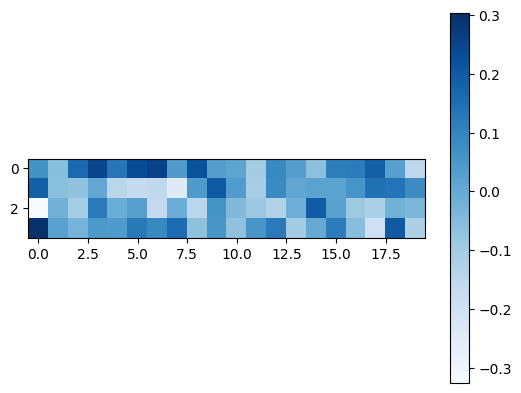

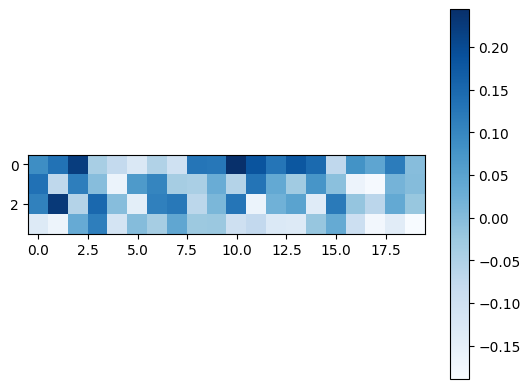

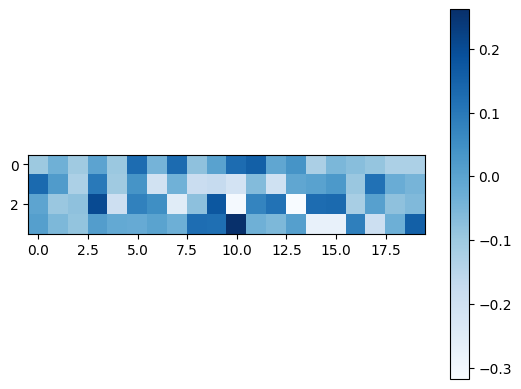

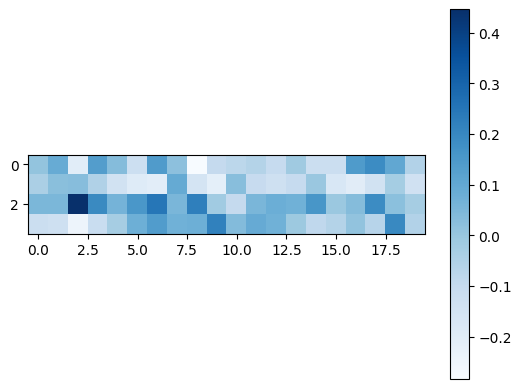

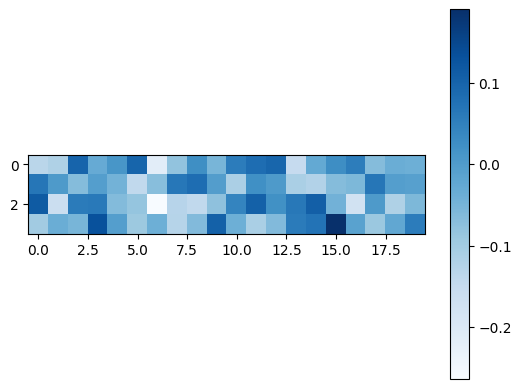

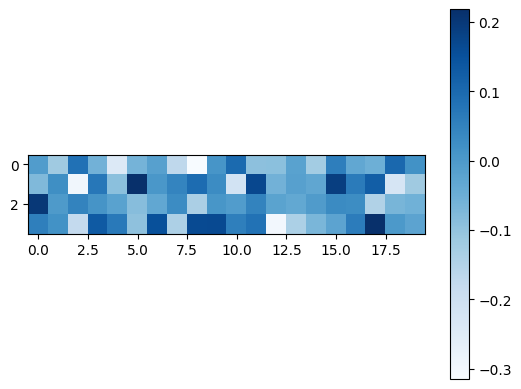

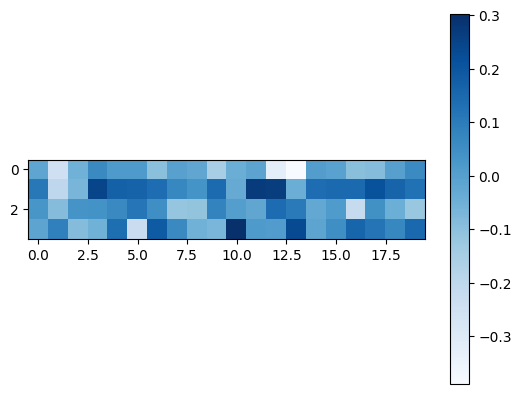

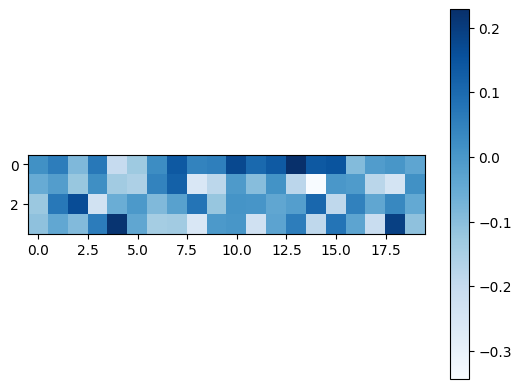

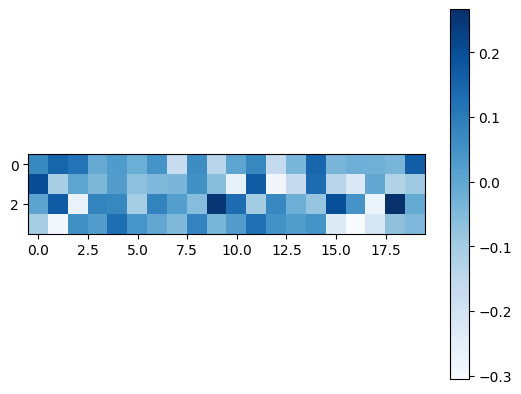

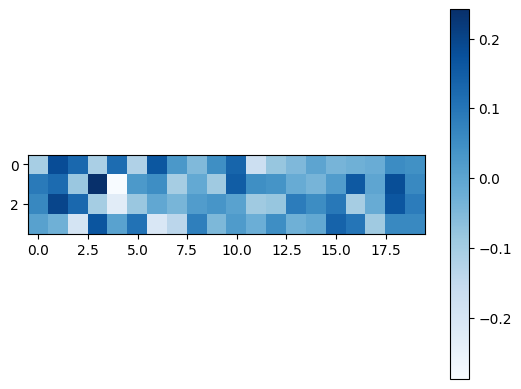

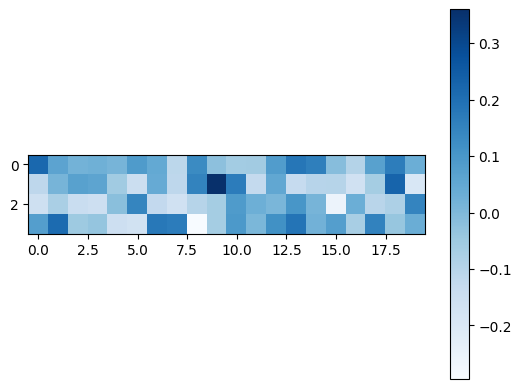

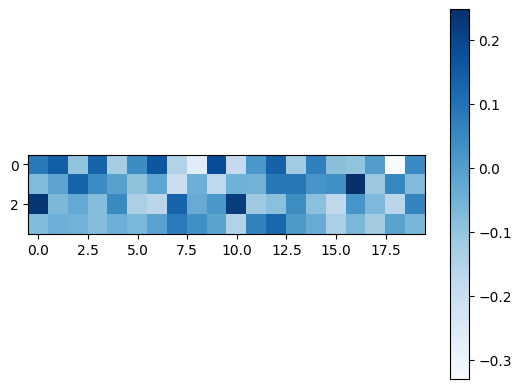

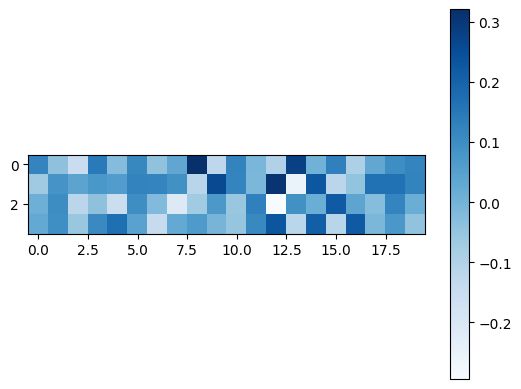

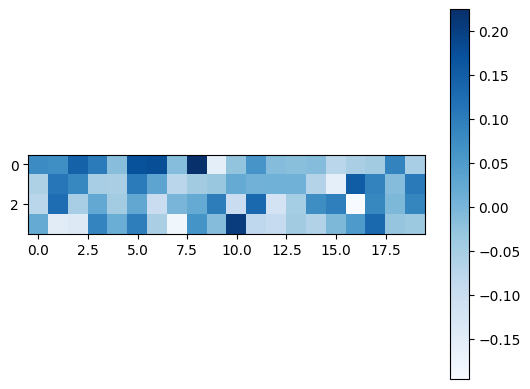

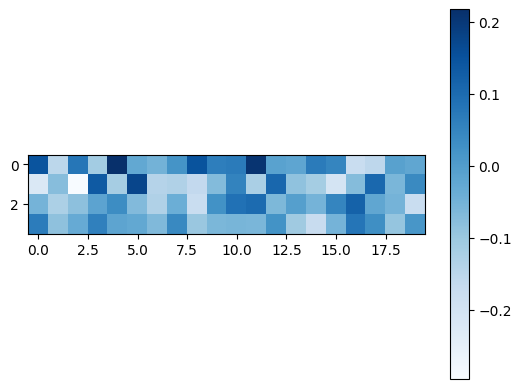

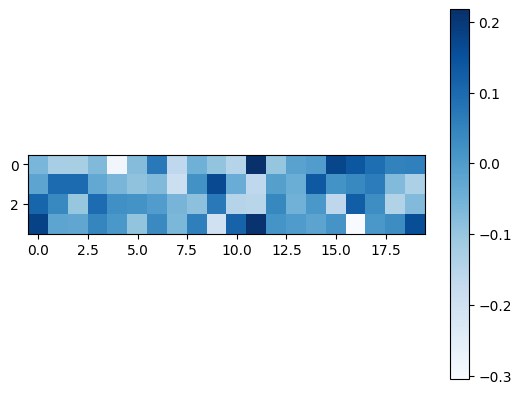

In [13]:
weights = model1.conv1_weights.detach().cpu().numpy()

# plot the convolutional filters:
for filter in range(len(weights)) :
    fig = plt.figure()
    plt.imshow(weights[filter],cmap="Blues")
    plt.colorbar()

Extracted 4327 sequences and saved to FASTA file.
Dataset created with 4327 positive examples and 4327 negative examples
Epoch 0
-------------------------------
training loss: 0.701726
Validation Accuracy: 0.507799
Avg test loss: 0.684069 

Epoch 10
-------------------------------
training loss: 0.303229
Validation Accuracy: 0.869440
Avg test loss: 0.344072 

Done!
AUC on validation data: 0.9682921098722713
AUC on testing data: 0.9606547132625102


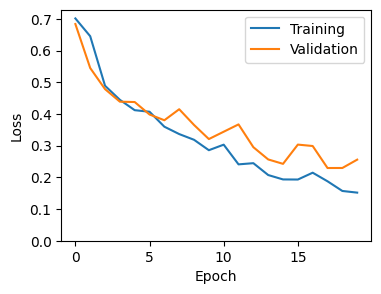

In [14]:
def test_cnn(bed_path, lr=0.001, stop_ratio=0.6, drop_out=None):

    # Load Data
    X, y = generate_dataset(get_sequences(bed_path=bed_path))

    X_train_data, X_temp_data, y_train_data, y_temp_data = train_test_split(X, y, test_size=0.4)
    X_valid_data, X_test_data, y_valid_data, y_test_data = train_test_split(X_temp_data, y_temp_data, test_size=0.5)
    # print(len(X_train_data))
    # print(len(X_temp_data))
    # print(len(X_valid_data))
    # print(len(X_test_data))

    train_dataset=chipseq_dataset([(x, y) for (x, y) in zip(X_train_data, y_train_data)])
    test_dataset=chipseq_dataset([(x, y) for (x, y) in zip(X_test_data, y_test_data)])
    valid_dataset=chipseq_dataset([(x, y) for (x, y) in zip(X_valid_data, y_valid_data)])
    # print(train_dataset[0])
    # print(valid_dataset[0])

    batch_size = 64
    train_loader = DataLoader(dataset=train_dataset,
                            batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset,
                            batch_size=batch_size,shuffle=True)

    # Build Model
    model = CNN(24, 20, 0.1, 0.1, drop_out=drop_out).to(device)
    optimizer = torch.optim.Adam(model.get_weights(), lr=lr)
    
    # optimizer = torch.optim.SGD(model.get_weights(),
    #                             lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-06);
    
    [train_loss, validation_loss] = train(model, train_loader, valid_loader, optimizer, stop_ratio)

    # Visualize Results
    plot_loss(*[train_loss, validation_loss])

    val_auc = validate_w_AUC(model, valid_loader)
    print(f'AUC on validation data: {val_auc}')

    test_auc = validate_w_AUC(model, test_loader)
    print(f'AUC on testing data: {test_auc}')

    return model, val_auc, test_auc

agl16_model, agl16_val_auc, agl16_test_auc = test_cnn(r'database\AGL16.target.all.bed')

Extracted 742 sequences and saved to FASTA file.
Dataset created with 742 positive examples and 742 negative examples
Epoch 0
-------------------------------
training loss: 0.795150
Validation Accuracy: 0.528620
Avg test loss: 0.690665 

Epoch 10
-------------------------------
training loss: 0.635814
Validation Accuracy: 0.592593
Avg test loss: 0.652239 

Epoch 20
-------------------------------
training loss: 0.425740
Validation Accuracy: 0.727273
Avg test loss: 0.510451 

Done!
AUC on validation data: 0.8719890510948904
AUC on testing data: 0.8835539809807943


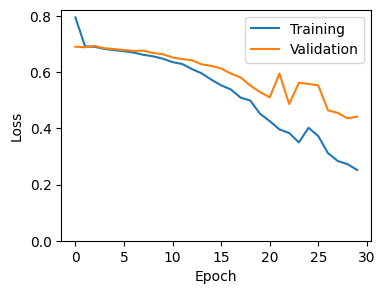

In [15]:
grf1_model, grf1_val_auc, grf1_test_auc = test_cnn(r'database\SRX021610.peak.all.bed')


Extracted 701 sequences and saved to FASTA file.
Dataset created with 701 positive examples and 701 negative examples
Epoch 0
-------------------------------
training loss: 0.696282
Validation Accuracy: 0.478571
Avg test loss: 0.691118 

Epoch 10
-------------------------------
training loss: 0.480349
Validation Accuracy: 0.628571
Avg test loss: 0.591610 

Done!
AUC on validation data: 0.8496109746109746
AUC on testing data: 0.8380281690140846


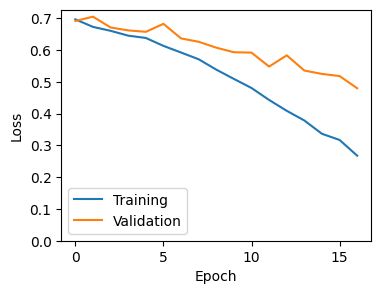

In [16]:
ams_model, ams_val_auc, ams_test_auc = test_cnn(r'database\SRX5507861.peak.all.bed')


In [17]:
""" 
This ended up being much more difficult then I thought it would be. 
The models ended up being heavily dependent on the initial parameters, 
mainly being learning rate and distribution of initial parameters. 

I emplemented a early stopping that seems to be doing well. It waits 
till the training and validation loss differ by > 40% and ends it then. 
This ends up getting pretty good AUC and will be explored in the future.
"""

' \nThis ended up being much more difficult then I thought it would be. \nThe models ended up being heavily dependent on the initial parameters, \nmainly being learning rate and distribution of initial parameters. \n\nI emplemented a early stopping that seems to be doing well. It waits \ntill the training and validation loss differ by > 40% and ends it then. \nThis ends up getting pretty good AUC and will be explored in the future.\n'

### Part 3:  experiments with network architecture and hyperparameters


With the implementation you created in Part 2, your next task is to explore the space of hyperparameters and architecture choices to determine their effect on the performance of your three-layer network.  Choose three aspects of the network to explore (e.g. the learning rate, whether dropout is helpful, the choice of activation function, etc.).  Discuss your results.  Which aspects of the model seem to have the most effect on the accuracy of the network?  Do the best parameter values vary from dataset to dataset?  Is your three layer network able to match or exceed the performance of a single layer network?  Hint:  it should!

In [18]:
import pandas as pd
import numpy as np

data = []


learning rate: 0.0001 
Extracted 701 sequences and saved to FASTA file.
Dataset created with 701 positive examples and 701 negative examples
Epoch 0
-------------------------------
training loss: 0.859714
Validation Accuracy: 0.482143
Avg test loss: 0.702708 

Epoch 10
-------------------------------
training loss: 0.667392
Validation Accuracy: 0.625000
Avg test loss: 0.671522 

Epoch 20
-------------------------------
training loss: 0.629962
Validation Accuracy: 0.667857
Avg test loss: 0.650175 

Epoch 30
-------------------------------
training loss: 0.592962
Validation Accuracy: 0.710714
Avg test loss: 0.619940 

Epoch 40
-------------------------------
training loss: 0.550017
Validation Accuracy: 0.735714
Avg test loss: 0.598183 

Epoch 50
-------------------------------
training loss: 0.499286
Validation Accuracy: 0.746429
Avg test loss: 0.578067 

Epoch 60
-------------------------------
training loss: 0.469960
Validation Accuracy: 0.742857
Avg test loss: 0.542320 

Epoch 70
----

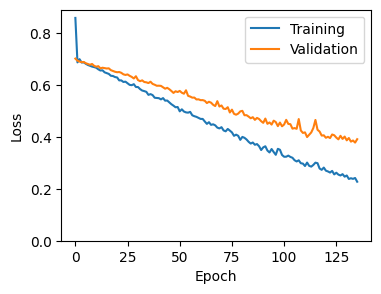

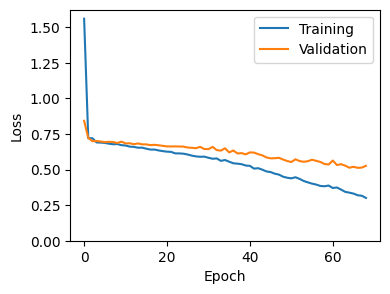

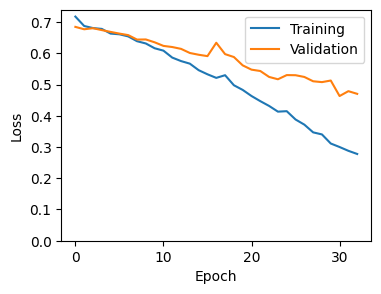

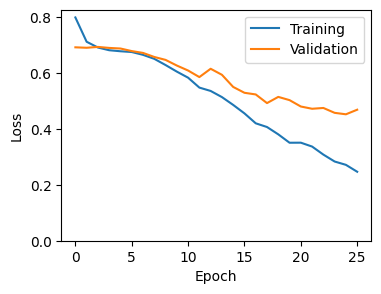

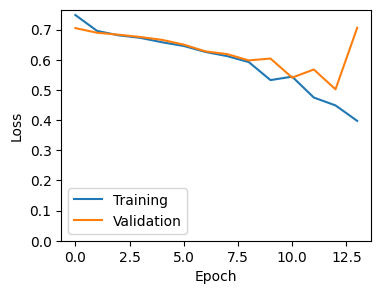

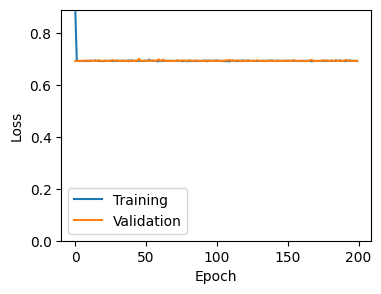

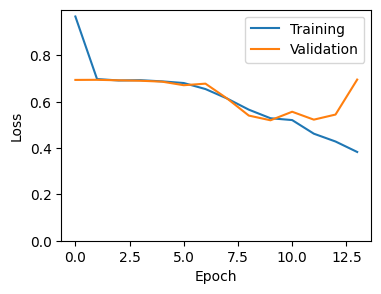

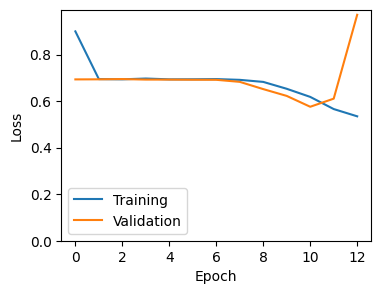

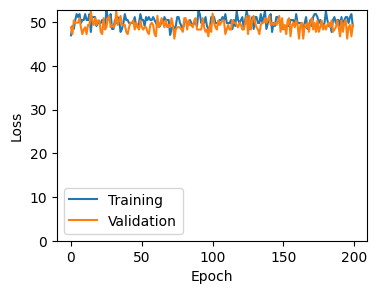

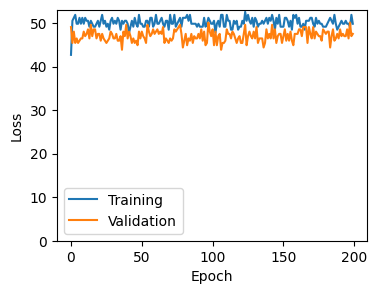

In [19]:
learning_rate_param_space = np.logspace(np.log10(0.0001), np.log10(0.1), 10)

val_curve = []
test_curve = []
for lr in learning_rate_param_space: 
    print(f'learning rate: {lr} \n ==================')
    _, val_auc, test_auc = test_cnn(r'database\SRX5507861.peak.all.bed', lr=lr)
    data.append(['AMS', 'learning_rate', lr, test_auc, val_auc])
    val_curve.append(val_auc)
    test_curve.append(test_auc)



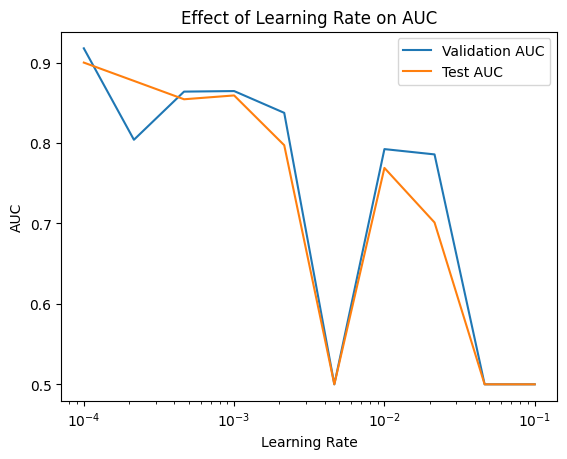

In [20]:
plt.plot(learning_rate_param_space, val_curve, label='Validation AUC')
plt.plot(learning_rate_param_space, test_curve, label='Test AUC')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('AUC')
plt.title('Effect of Learning Rate on AUC')
plt.legend()
plt.show()

stopping ratio: 0.0 
Extracted 742 sequences and saved to FASTA file.
Dataset created with 742 positive examples and 742 negative examples
Epoch 0
-------------------------------
training loss: 0.747465
Validation Accuracy: 0.515152
Avg test loss: 0.700519 

Epoch 10
-------------------------------
training loss: 0.514630
Validation Accuracy: 0.653199
Avg test loss: 0.601085 

Epoch 20
-------------------------------
training loss: 0.212858
Validation Accuracy: 0.824916
Avg test loss: 0.402895 

Epoch 30
-------------------------------
training loss: 0.063638
Validation Accuracy: 0.841751
Avg test loss: 0.366321 

Epoch 40
-------------------------------
training loss: 0.023902
Validation Accuracy: 0.855219
Avg test loss: 0.322153 

Epoch 50
-------------------------------
training loss: 0.011378
Validation Accuracy: 0.858586
Avg test loss: 0.330097 

Epoch 60
-------------------------------
training loss: 0.006838
Validation Accuracy: 0.851852
Avg test loss: 0.309664 

Epoch 70
------

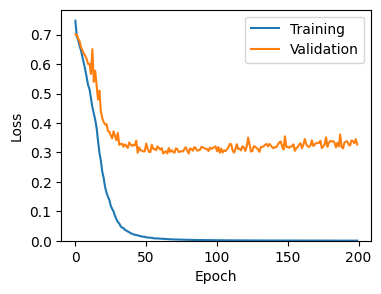

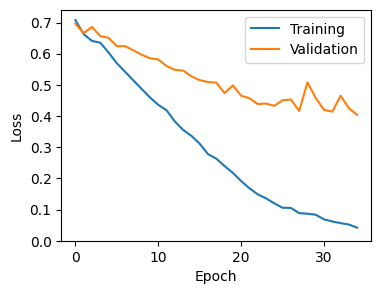

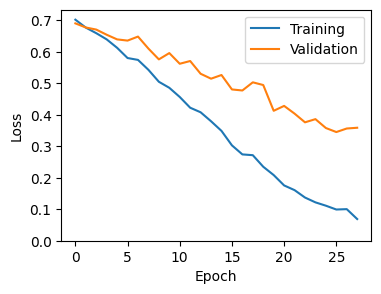

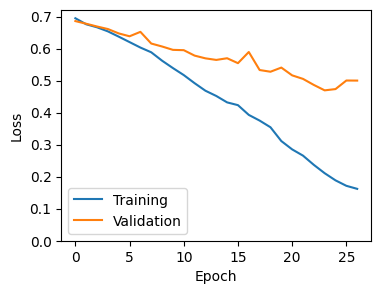

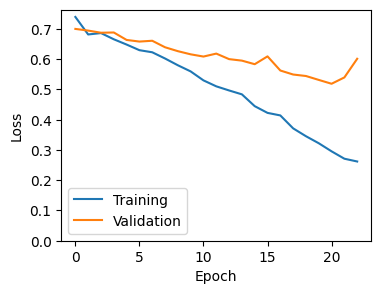

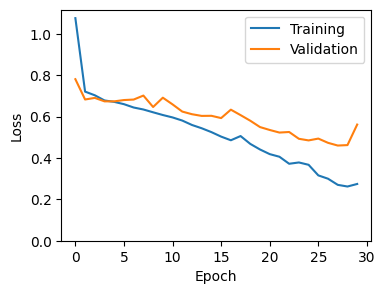

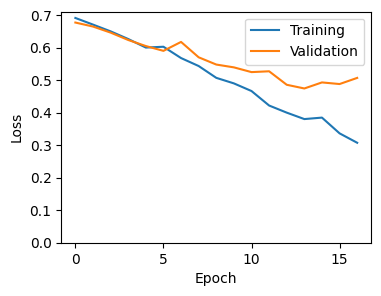

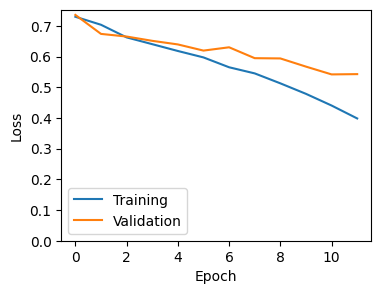

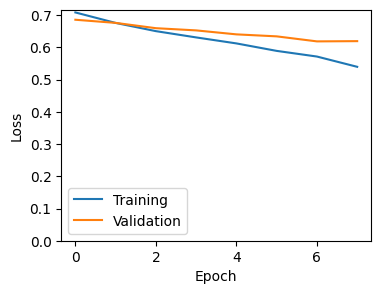

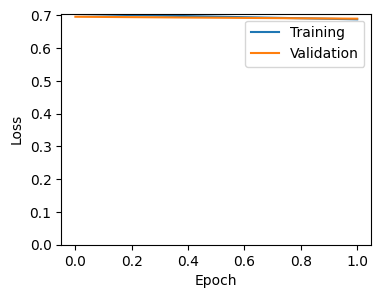

In [21]:
stopping_ratio_param_space = np.linspace(0, 1, 10)

val_curve = []
test_curve = []
for sr in stopping_ratio_param_space: 
    print(f'stopping ratio: {sr} \n ==================')
    _, val_auc, test_auc = test_cnn(r'database\SRX021610.peak.all.bed', stop_ratio=sr)
    data.append(['GRF1', 'stopping_ratio', sr, test_auc, val_auc])
    val_curve.append(val_auc)
    test_curve.append(test_auc)



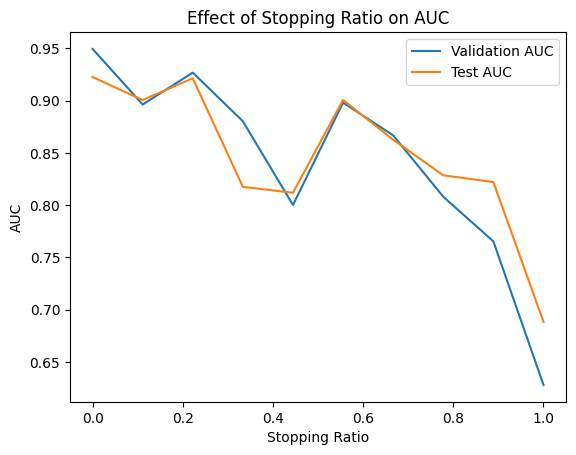

In [22]:
plt.plot(stopping_ratio_param_space, val_curve, label='Validation AUC')
plt.plot(stopping_ratio_param_space, test_curve, label='Test AUC')
plt.xlabel('Stopping Ratio')
plt.ylabel('AUC')
plt.title('Effect of Stopping Ratio on AUC')
plt.legend()
plt.show()

learning rate: 0.05 
Extracted 701 sequences and saved to FASTA file.
Dataset created with 701 positive examples and 701 negative examples
Epoch 0
-------------------------------
training loss: 0.719475
Validation Accuracy: 0.489286
Avg test loss: 0.695894 

Epoch 10
-------------------------------
training loss: 0.634454
Validation Accuracy: 0.696429
Avg test loss: 0.645477 

Epoch 20
-------------------------------
training loss: 0.385217
Validation Accuracy: 0.764286
Avg test loss: 0.504580 

Done!
AUC on validation data: 0.8522392767031118
AUC on testing data: 0.8815896188158961
learning rate: 0.14444444444444443 
Extracted 701 sequences and saved to FASTA file.
Dataset created with 701 positive examples and 701 negative examples
Epoch 0
-------------------------------
training loss: 0.735897
Validation Accuracy: 0.496429
Avg test loss: 0.698114 

Epoch 10
-------------------------------
training loss: 0.653438
Validation Accuracy: 0.496429
Avg test loss: 0.655862 

Epoch 20
------

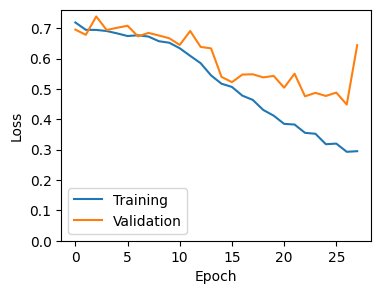

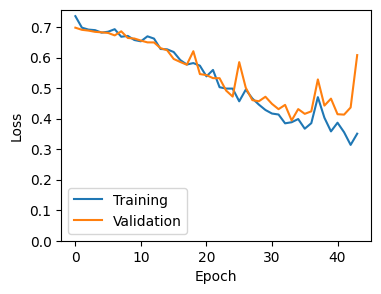

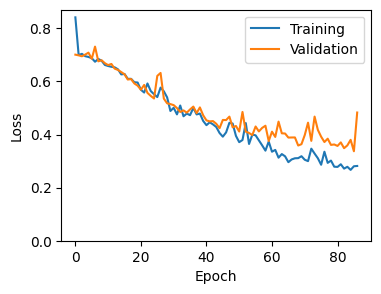

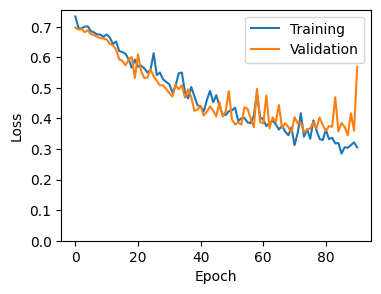

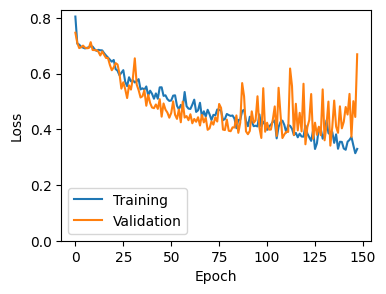

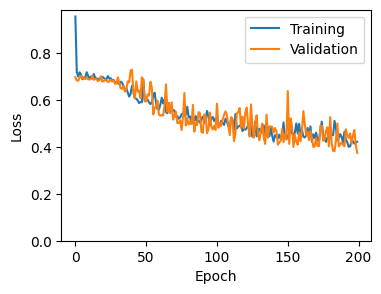

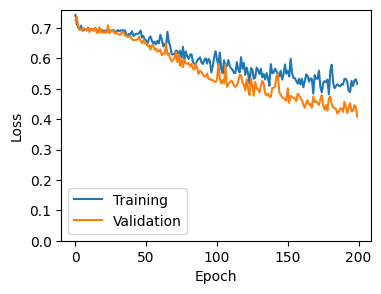

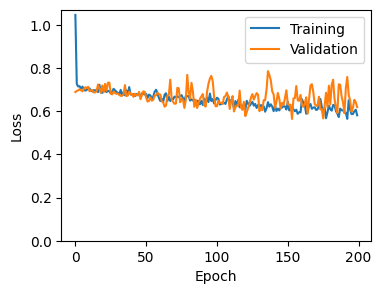

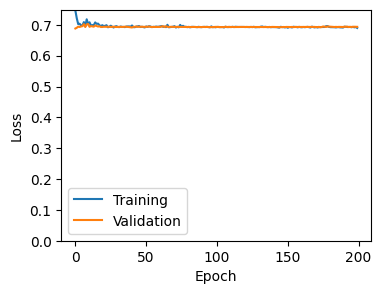

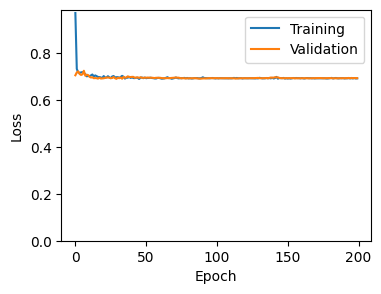

In [ ]:
drop_out_param_space = np.linspace(0.05, 0.9, 10)

val_curve = []
test_curve = []
for do in drop_out_param_space: 
    print(f'drop out: {do} \n ==================')
    _, val_auc, test_auc = test_cnn(r'database\SRX5507861.peak.all.bed', drop_out=do)
    data.append(['AMS', 'dropout', do, test_auc, val_auc])
    val_curve.append(val_auc)
    test_curve.append(test_auc)



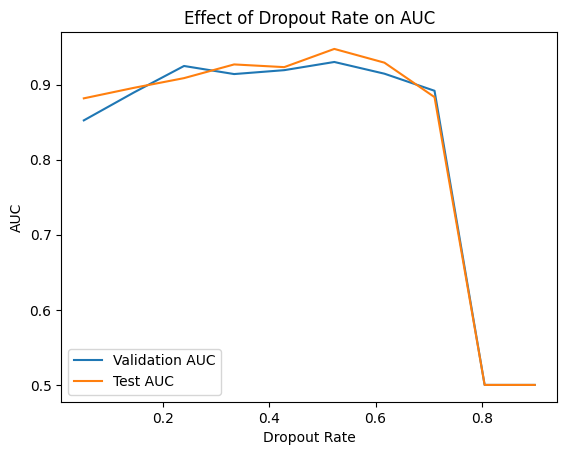

In [24]:
plt.plot(drop_out_param_space, val_curve, label='Validation AUC')
plt.plot(drop_out_param_space, test_curve, label='Test AUC')
plt.xlabel('Dropout Rate')
plt.ylabel('AUC')
plt.title('Effect of Dropout Rate on AUC')
plt.legend()
plt.show()

In [25]:
data = pd.DataFrame(data, columns = ['Dataset', 'Hyperparameter', 'Value', 'testing_auc', 'validation_auc'])

In [26]:
data

,Dataset,Hyperparameter,Value,testing_auc,validation_auc
0,AMS,learning_rate,0.000100,0.900020,0.917752
1,AMS,learning_rate,0.000215,0.877268,0.804054
2,AMS,learning_rate,0.000464,0.854414,0.863922
3,AMS,learning_rate,0.001000,0.859174,0.864615
4,AMS,learning_rate,0.002154,0.797282,0.837520
5,AMS,learning_rate,0.004642,0.500000,0.500000
6,AMS,learning_rate,0.010000,0.769051,0.792456
7,AMS,learning_rate,0.021544,0.701217,0.785856
8,AMS,learning_rate,0.046416,0.500000,0.500000
9,AMS,learning_rate,0.100000,0.500000,0.500000


In [27]:
""" 
Discussion:

 - So to get the models training took quite a while. It turns out 
the learning rate and the distribution of initial parameters 
was messing with my ability to get consistent results. Because of 
learning rate is goint ot one of primary ones that I will vary

 - This is kinda funny. I was originally struggling to find a learning 
rate that effiently trained. Turn out for the default parameters, the learning 
rate can be in a pretty wide range and preform fine. However, where I was originally 
check where two pits where the learning rate cause the model to fail.

 - After looking at the graph of early stopping, it is very obvious what is going on. The more 
training the better the preformance. This makes a ton of sense. 

 - The input outdrop was interesting. The model preformed better the best of a drop out of 0.2 - 0.6 meaning,
it was dropping 20 to 60% of the input. This makes some sense because motifs often have interchangable nucleotides in 
a given position. However, it still is counter intuitive because more data typically means better fit. 
"""

' \nDiscussion:\n\n - So to get the models training took quite a while. It turns out \nthe learning rate and the distribution of initial parameters \nwas messing with my ability to get consistent results. Because of \nlearning rate is goint ot one of primary ones that I will vary\n\n - This is kinda funny. I was originally struggling to find a learning \nrate that effiently trained. Turn out for the default parameters, the learning \nrate can be in a pretty wide range and preform fine. However, where I was originally \ncheck where two pits where the learning rate cause the model to fail.\n\n - After looking at the graph of early stopping, it is very obvious what is going on. The more \ntraining the better the preformance. This makes a ton of sense. \n\n - The input outdrop was interesting. The model preformed better the best of a drop out of 0.2 - 0.6 meaning,\nit was dropping 20 to 60% of the input. This makes some sense because motifs often have interchangable nucleotides in \na give

### Coding and reporting your results

In your notebook, I do not want to see repetitive code.  Such code belongs in a function!
In your reporting, make sure your results are clearly presented.  I recommend using a table format, and your table can be populated by your code.  pandas DataFrame objects render nicely in Jupyter notebooks.  Here's an example:


#### Grading

```
Part 1: dataset creation (20 pts)
Part 2: implementation of three layer network, early stopping, and multiple training (40 pts)
Part 3: experiments on network architecture (40 pts)
```